In [1]:
# import os
# os.mkdir("S8")
# with open('model.py', 'w') as fp: 
#     pass
# %cd ..
# %cd ..
import shutil
try:
  shutil.rmtree("./EVA5")
except:
  pass

In [2]:
!git clone https://github.com/abishek-raju/EVA5.git

Cloning into 'EVA5'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 104 (delta 6), reused 20 (delta 3), pack-reused 81
Receiving objects: 100% (104/104), 79.74 MiB | 33.18 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
# %ls

In [4]:
%cd EVA5/S9

/content/EVA5/S9


In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cuda'

In [8]:
from dataloader import load_cifar_data

In [9]:
trn_loader ,test_loader, classes = load_cifar_data()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
from model import ResNet18

In [11]:
net = ResNet18(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [13]:
from train import train
from test import test

In [14]:
def save_checkpoint(checkpoint,file_name = "model.pth.tar"):
  print(f"Saving model to {file_name}")
  torch.save(checkpoint,file_name)


In [15]:
def load_checkpoint(file_name):
  print(f"Loading checkpoint from {file_name}")
  checkpoint = torch.load(file_name)
  net.load_state_dict(checkpoint["state-dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

In [16]:
# best_accuracy = 0
# for epoch in range(0,40):
#     train_average_loss,train_accuracy = train(epoch,net,device,trn_loader,optimizer,criterion)
#     test_average_loss,test_accuracy = test(epoch,net,test_loader,device,criterion)
#     print(f'\nEpoch: {epoch}\n\t Train set: Average loss: {train_average_loss}, Accuracy: {train_accuracy}%')
#     print(f'\n\tTest set: Average loss: {test_average_loss}, Accuracy: {test_accuracy}%')
#     if test_accuracy > best_accuracy:
#       best_accuracy = test_accuracy
#       checkpoint = {'state-dict':net.state_dict(),'optimizer':optimizer.state_dict()}
#       save_checkpoint(checkpoint)
#     scheduler.step()

In [17]:
load_checkpoint("./model.pth.tar")

Loading checkpoint from ./model.pth.tar


In [18]:
try:
  shutil.rmtree("/content/EVA5/S9/cifar_test_single")
except:
  pass

In [19]:
import shutil
import os
destination = shutil.copytree("/content/EVA5/S9/cifar_test", "/content/EVA5/S9/cifar_test_single") 
# os.remove("/content/EVA5/S9/cifar_test_single/just_a_folder/cars_1.jpeg")
os.remove("/content/EVA5/S9/cifar_test_single/just_a_folder/cars_2.jpeg")
os.remove("/content/EVA5/S9/cifar_test_single/just_a_folder/plane_1.jpg")
os.remove("/content/EVA5/S9/cifar_test_single/just_a_folder/plane_2.jpeg")

In [20]:
net.to(device)
net.eval()
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Resize((32,32))])
transform_test_without_resize = transforms.Compose([
    transforms.ToTensor()])
# dataset = {'predict' : datasets.ImageFolder("/content/EVA5/S9/cifar_test_single", transform_test)}
# dataloader = {'predict': torch.utils.data.DataLoader(dataset['predict'], batch_size = 1, shuffle=False, num_workers=4)}

# outputs = list()
# for inputs, labels in dataloader['predict']:
#     inputs = inputs.to(device)
#     output = net(inputs)
#     output = output.to(device)
#     index = output.cpu().data.numpy().argmax()
#     print(index)

In [21]:
from PIL import Image
from torch.autograd import Variable
def image_loader(image_name,device):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    original_image = Image.open(image_name)
    # original_image = transform_test_without_resize(original_image)
    image = transform_test(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device), original_image #assumes that you're using GPU

In [22]:
# temp = np.array(orgi)
# temp.shape

In [23]:
# net

In [24]:
# net.module.layer4[1].conv2

In [25]:
# res50_model.module

In [26]:
# temp = nn.Sequential(*list(net.children()))

In [27]:
# outputs= []
# def hook(module, input, output):
#     outputs.append(output)

# res50_model = net
# res50_model.module.layer4[0].conv2.register_forward_hook(hook)
# out = res50_model(res)
# out = res50_model(res1)
# print(outputs)

In [28]:
# list(net.children())[0].children

In [29]:
# nn.Sequential(*list(original_model.children())[:-2])

In [30]:
# nn.Sequential(*list(net.module.children()))

In [31]:
class Grad_Res(nn.Module):
    def __init__(self,model):
        super().__init__()
        
        # get the pretrained VGG19 network
        self.res_model = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(self.res_model.module.children())[:-2])
        # self.features_conv = self.vgg.features[:36]
        
        # # get the max pool of the features stem
        # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.classifier1 = list(self.res_model.module.children())[-2:][0]
        self.classifier2 = list(self.res_model.module.children())[-2:][1]

        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # print("aaaaaa")
        # register the hook
        h = x.register_hook(self.activations_hook)
        # print("bbbbbb")
        print(x.shape)
        # apply the remaining pooling
        x = self.classifier1(x)
        # print("before linear",x.shape)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.classifier2(x)
        # print("cccccc")
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [48]:
def grad_cam_view(class_of_interest,img,device):
  classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')
  grad_res = Grad_Res(net)
  grad_res.eval()
  img = img.to(device)
  pred = grad_res(img)
  print(f"\n\npredicted class {classes[pred.argmax(dim=1)[0]]}")
  if class_of_interest is None:
    class_of_interest = pred.argmax(dim=1)
  pred[:,class_of_interest].backward()
  gradients = grad_res.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = grad_res.get_activations(img).detach()
  for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = np.maximum(heatmap.cpu(), 0)
  heatmap /= torch.max(heatmap)
  return heatmap
# classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')
# img, _ = next(iter(dataloader['predict']))
# heatmap_generated = grad_cam_view(1,img,device)

In [33]:
# img,orgi = image_loader("/content/EVA5/S9/cifar_test/just_a_folder/plane_1.jpg",device)


torch.Size([1, 256, 8, 8])


predicted class horse


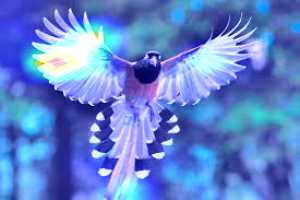

torch.Size([1, 256, 8, 8])


predicted class ship


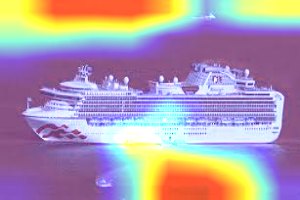

torch.Size([1, 256, 8, 8])


predicted class car


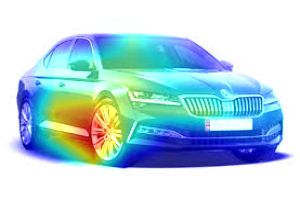

torch.Size([1, 256, 8, 8])


predicted class car


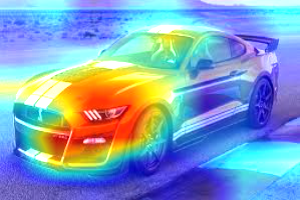

torch.Size([1, 256, 8, 8])


predicted class horse


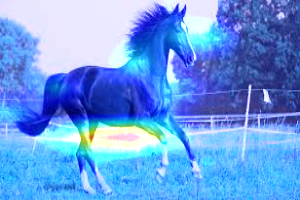

torch.Size([1, 256, 8, 8])


predicted class plane


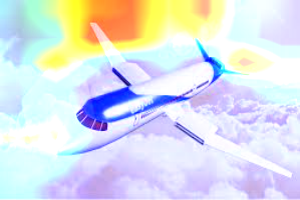

torch.Size([1, 256, 8, 8])


predicted class bird


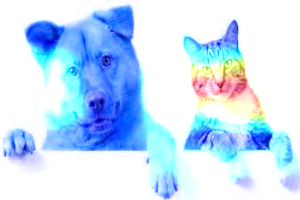

torch.Size([1, 256, 8, 8])


predicted class horse


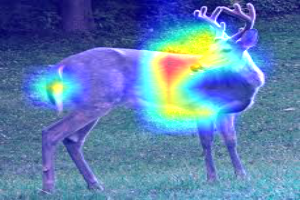

torch.Size([1, 256, 8, 8])


predicted class plane


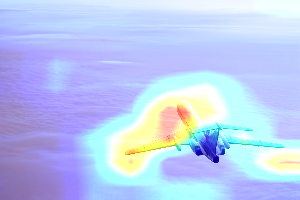

torch.Size([1, 256, 8, 8])


predicted class car


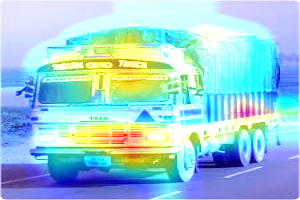

torch.Size([1, 256, 8, 8])


predicted class bird


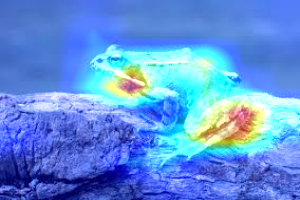

In [49]:
from google.colab.patches import cv2_imshow
import cv2
for image_name in os.listdir("/content/EVA5/S9/cifar_test/just_a_folder"):
  img,orgi = image_loader("/content/EVA5/S9/cifar_test/just_a_folder/"+image_name,device)
  # classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

  heatmap_generated = grad_cam_view(None,img,device)

  # temp = cv2.imread('/content/EVA5/S9/cifar_test_single/just_a_folder/cars_1.jpeg')
  # temp = orgi.permute(1, 2, 0).numpy()
  temp = np.array(orgi)
  # temp = Image.fromarray(temp)
  heatmap = cv2.resize(heatmap_generated.numpy(), (temp.shape[1], temp.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.7+ Image.fromarray(temp)
  # superimposed_img_resized = cv2.resize(superimposed_img, (200, 200))
  # cv2.imwrite('./map.jpg', superimposed_img)
  cv2_imshow(cv2.resize(superimposed_img,(300,200)))
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [ ]:
# # initialize the VGG model
# vgg = VGG(net)

# # set the evaluation mode
# vgg.eval()

# # get the image from the dataloader
# img, _ = next(iter(dataloader['predict']))
# img = img.to(device)
# # get the most likely prediction of the model
# pred = vgg(img)

In [ ]:
# pred

In [ ]:
# pred[:,1].backward()

In [ ]:
# gradients = vgg.get_activations_gradient()

In [ ]:
# pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [ ]:
# activations = vgg.get_activations(img).detach()

In [ ]:
# pooled_gradients.shape

In [ ]:
# activations.shape

In [ ]:
# for i in range(256):
#     activations[:, i, :, :] *= pooled_gradients[i]

In [ ]:
# heatmap = torch.mean(activations, dim=1).squeeze()

In [ ]:
# import numpy as np
# np.maximum(heatmap.cpu(), 0)

In [ ]:
# heatmap = np.maximum(heatmap.cpu(), 0)

In [ ]:
# heatmap /= torch.max(heatmap)

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# plt.matshow(heatmap.squeeze())

In [ ]:
# img

In [ ]:
# plt.matshow(np.transpose(img[0].cpu(),(1,2,0)))

In [ ]:
# heatmap.numpy()

In [ ]:
orgi

In [ ]:
temp

In [ ]:
temp = orgi.permute(1, 2, 0).numpy()
temp.shape

In [ ]:
img, _ = next(iter(dataloader['predict']))

In [ ]:
img[0].permute(1, 2, 0).numpy()

In [ ]:
# import os
# os.getcwd()